In [1]:
try:
    import rlmep

    print("Already installed")
except ImportError:
    %pip install "rlmep @ git+https://github.com/Mads-PeterVC/rlmep.git" # if you are using Google Colab

Already installed


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from ase.calculators.emt import EMT
from ase.visualize import view

from rlmep.data import get_cluster_data
from rlmep.exercise_1 import DQN, ExperienceReplay
from rlmep.exercise_2 import GridSpec, plot_qvalues
from rlmep.exercise_2.discrete_mep_scaffold import (
    ScaffoldDiscreteMEP,
    _get_cheat_functions,
)
from rlmep.exercise_3 import plot_levels


### (Slightly) More interesting example.

I've created a slightly more interesting problem where the atom does not move in a straight line,
but has to move around (a few) other atoms in two-dimensional space.

I've created three 'levels' for this problem with the atom starting in different positions,
set by the `level` parameter (`0`, `1`, or `2`).

Below, the initial and final configurations for the three levels are shown.

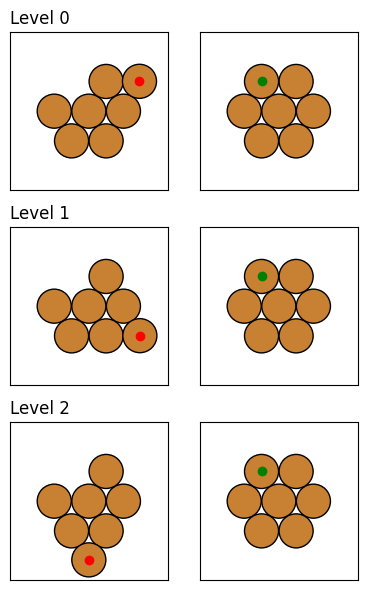

In [3]:
plot_levels()

For now, let's load the most simple case, level 0.

In [4]:
initial_config, final_config = get_cluster_data(level=0)

We need to setup the environment which involves a few steps; 

Setting up the grid: 
- Choose the `grid_size`
- Choose a `grid_spacing`
- Choose the lower-left `corner` of the grid in (x, y)-coordinates.
- Choose the z-coordinate of the moving atom.

Hyperparameters; 
- `barrier_max`: The barrier that corresponds to a reward of 0 ($\Delta_{\mathrm{max}}$ in the reward function).
- `reward_scale`: Corresponds to $A$ in the reward function.

Others; 
- `moving_atom`: is the index of the atom being moved - in this case the last atom.

#### Exercise: 

Set up the environment, do some sanity checking and then try having the DQN algorithm 
solve the problem.

Once you've solved level 0, try one of the others. 

<details>
<summary> <strong> Hint: Grid level 0 </strong> </summary>

For level 0 this grid is solvable for me.

```python
grid_spec = GridSpec(
    grid_size=(15, 8),
    grid_spacing=0.5,
    corner=(10, 14),
    height=initial_config.positions[0][2],
```
</details>
<br> 

<details>
<summary> <strong> Hint: Settings level 0 </strong> </summary>

I've found 
```python
barrier_max = 2.5
reward_scale = 10.0
distance_parameter = 0.1
```
to work.

<br> 

In [6]:
# My versions of the functions from exercise 2 (`check_terminal`, `check_truncated`, etc.)
functions = _get_cheat_functions()

initial_config, final_config = get_cluster_data(level=0)

grid_spec = GridSpec(
    grid_size=(15, 8),
    grid_spacing=0.5,
    corner=(10, 14),
    height=initial_config.positions[0, 2],
)

env = ScaffoldDiscreteMEP(
    initial_config=initial_config,
    final_config=final_config,
    gridspec=grid_spec,
    functions=functions,
    moving_atom=-1,
    max_steps=100,
    barrier_max=2.5, # Your decision here
    reward_scale=10, # Your decision here
    distance_parameter=0.1, # Your decision here
    calculator=EMT(),
)

Text(0.5, 1.0, 'Return: 5.17 \n Barrier: 1.43')

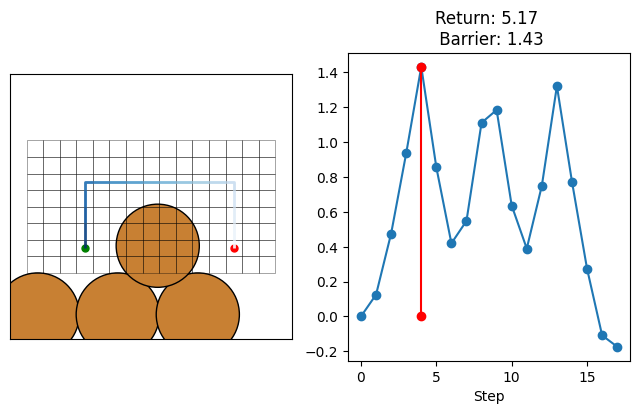

In [7]:
# Perform a rollout to visualize a path in the environment
state, _ = env.reset()

x_steps = 9
y_steps = 4
action_sequence = [2] * y_steps + [1] * x_steps + [3] * y_steps  # up → right → down
state_history = [state]
return_value = 0
for action in action_sequence:
    state, reward, terminal, truncated, info = env.step(action)
    state_history.append(state)
    return_value += reward
    if terminal or truncated:
        break

fig, ax = plt.subplots(1, 2, figsize=(2 * 4, 4))

env.reset()
env.visualize(ax=ax[0], dx=0.5, dy=2, plot_moving=False, state_history=state_history)

delta_path = info["history"]
max_barrier = np.max(delta_path)
index_max = np.argmax(delta_path)

ax[1].plot(delta_path, "-o", label="Energy")
ax[1].plot([index_max, index_max], [0, max_barrier], "-ro", label=f"Max Barrier: {max}")
ax[1].set_xlabel("Step")
ax[1].set_title(f"Return: {return_value:0.2f} \n Barrier: {max_barrier:0.2f}")


You can again either use my implementation or plug in your own for `Qnet` and `DQN` below

In [8]:
from rlmep.exercise_1.dqn_learner import DQN
from rlmep.exercise_1.qnet import Qnet

In [13]:
env.reset()

# Set the action and observation dimensions:
obs_dim = 2
n_actions = 4

# Set the network settings:
main_network = Qnet(input_dim=obs_dim, output_dim=n_actions)
target_network = Qnet(input_dim=obs_dim, output_dim=n_actions)
replay = ExperienceReplay(observation_dim=obs_dim, size=2000, batch_size=32)

# Make a learner:
learner = DQN(
    main_network,
    target_network,
    replay,
    gamma=0.90,
    train_interval=1,
    copy_interval=100,
    epsilon=lambda i: 0.5
)
num_episodes = 2500
returns, lengths = learner.learn(
    env=env,
    num_episodes=num_episodes,
)

return_value, states = learner.rollout(env, episode=0, train=False, apply_epsilon=False)

Output()

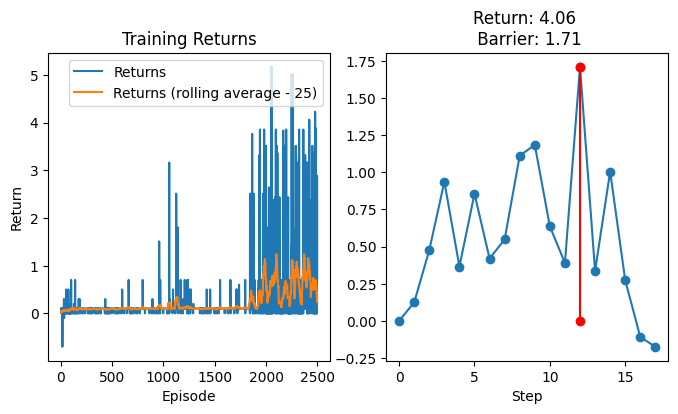

In [14]:
from rlmep.utils.plot_returns import plot_returns


fig, ax = plt.subplots(1, 2, figsize=(8, 4))

plot_returns(ax[0], returns, window=25)

delta_path = env.history
max_barrier = np.max(delta_path)
index_max = np.argmax(delta_path)
ax[1].plot(delta_path, "-o", label="Energy")
ax[1].plot([index_max, index_max], [0, max_barrier], "-ro")
ax[1].set_xlabel("Step")
ax[1].set_title(f"Return: {return_value:0.2f} \n Barrier: {max_barrier:0.2f}");


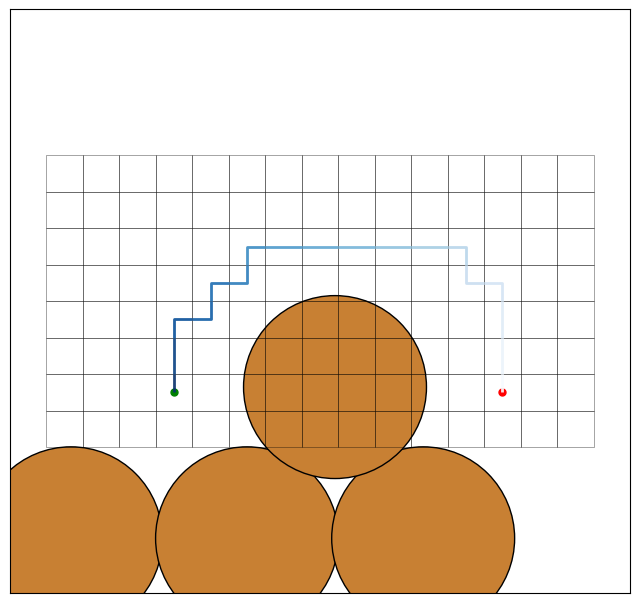

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

Q_table_nn = np.zeros((env.gridspec.grid_size[0], env.gridspec.grid_size[1], 4))
for i in range(env.gridspec.grid_size[0]):
    for j in range(env.gridspec.grid_size[1]):
        Q_table_nn[i, j, :] = (
            main_network(torch.tensor([i, j], dtype=torch.float))
            .detach()
            .numpy()
            .flatten()
        )

env.reset()
env.visualize(ax=ax, dx=0.5, dy=2, plot_moving=False, state_history=states)
# ax = plot_qvalues(ax, Q_table_nn, env, alpha=0.5)

## Domain knowledge

Obviously this agent is not the strongest - one problem in particular is that it 
doesn't *transfer* at all. Training on this problem does not help for another problem -
at least not in general. 

This can most likely be improved by incorporating techniques used in modern MLIPs.
Specifically the reason that there is no transfer is that the networks use a state 
representation that does not generalize at all. 

So a few ideas to improve on this are; 

- Use an invariant feature of the moving atom to predict actions
    - I think this would already be helpful.
    - However, I suspect that problems can arise from states that have the same invariant features, but different actions should be taken. 
- Rather than using an invariant feature of the state to predict all of the Q-values for each action, use invariant features of the state that an action would lead to. 
    - For our setup with 4 actions this means e.g. moving the atom to each adjacent grid-point and calculating SOAP features. 
    - Feed each of these four SOAP vectors through a network to predict $Q(s, a)$. 
- Use equivariant vector features
    - E.g. for the moving predict a vector, like the force, and use that vector to predict Q-values.
    - E.g. the dot-product between the vector and the grid-direction, so the Q-value for up would be $Q(s, \uparrow) = \vec{v}_{\theta}(s) \cdot \uparrow$ where $\vec{v}_{\theta}(s)$ is the predicted equivariant vector. 
- Finally equivariance would also allow the problem to be restated as an environment with both a continuous action and state space. 
    - Requires using different RL algorithms - probably a policy gradient method.    

Of course the environment can, and to be useful should, also be extended to moving more 
atoms simultaneously. One idea to do so; 

- Reformulate the action space to be the acceleration-vector on each atom. 
    - Have an MD-type driver propagate the system based on the RL-predicted acceleration vector.

#### The exercise that makes sure you won't finish everything

If you've come this far and want another exercise try to implement a Q-network that uses invariant features of the moving atom. 

To get started on that I suggest doing the following; 

1. Decide on an atomic feature, e.g. SOAP/symmetry functions - or the output of an invariant neural network. 
2. Adapt our `Qnet` to take this input (It basically can already, just need to adjust the input dimension)
3. Train this network towards a Q-map from one of the current agents or some handcrafted ones.
4. Train the network on half the Q-values of the current network and see if it generalizes. 
5. Try DQN with that network.